In [51]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# load local model file and initialize model class
from model import ModelClass

model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

model.solve()
model.simulate()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
df = pd.read_csv('Data/formue_total.csv')
wealth = df[(df['gender']=='Man')]
df = pd.read_csv('Data/salary_hours.csv')
salary_and_hours = df[(df['gender']=='Man')]

s_mean = np.array(wealth['pension_assets_Mean'])
s_stderr = np.array(wealth['pension_assets_StdErr'])

a_mean = np.array(wealth['nettoform_u_pf_Mean'])
a_stderr = np.array(wealth['nettoform_u_pf_StdErr'])

h_mean = np.array(salary_and_hours['yearly_hours_Mean'])/par.full_time_hours
h_mean_full = np.concatenate((np.array(salary_and_hours['yearly_hours_Mean'])/par.full_time_hours, np.zeros(par.retirement_age)))
h_stderr = np.array(salary_and_hours['yearly_hours_StdErr'])/par.full_time_hours
h_stderr_full = np.concatenate((np.array(salary_and_hours['yearly_hours_StdErr'])/par.full_time_hours, np.zeros(par.retirement_age)))

# Concatenate into final scaled data moments
moment_mean = np.concatenate((s_mean, a_mean, h_mean))
variance = np.concatenate((s_stderr, a_stderr, h_stderr))

moment_weight = np.diag(1 / variance**2)

In [ ]:
def moment_func(sim_data):
    # Compute age-averaged moments
    avg_s_by_age = np.mean(sim_data.s, axis=0)  # Length 70
    avg_a_by_age = np.mean(sim_data.a, axis=0)  # Length 70
    avg_h_by_age = np.mean(sim_data.h, axis=0)  # Length 70

    # Truncate h to first 35
    avg_h_by_age_trunc = avg_h_by_age[:35]

    # Concatenate and return
    return np.concatenate((avg_s_by_age, avg_a_by_age, avg_h_by_age_trunc))


def simulate_moments(theta, theta_names, model):
        
    # 1. Update model parameters
    for i, name in enumerate(theta_names):
        setattr(model.par, name, theta[i])
    
    # 2. Solve and simulate the model
    model.solve()
    model.simulate()
    
    # 3. Return the expanded vector of simulated moments
    return moment_func(model.sim)

def obj_func(theta, theta_names, mom_data, W, model, do_print=False):
    start_time = time.time()  # Start timing

    if do_print: 
        print_str = ''
        for i, name in enumerate(theta_names):
            print_str += f'{name}={theta[i]:2.3f} '
        print(print_str)
    
    # Compute simulated moments
    mom_sim = simulate_moments(theta, theta_names, model)

    # Sum of squared errors over all 175 elements
    obj = (mom_data - mom_sim).T @ W @ (mom_data - mom_sim)

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    
    if do_print: 
        print(f"Error = {obj:.6f}, Time = {elapsed_time:.4f} seconds")

    return obj

In [113]:
theta_names = ("beta", "sigma", "gamma", "mu", "r_s", "r_a")

objective = lambda theta: obj_func(theta, theta_names, moment_mean, moment_weight, model, do_print=True)

theta_init = np.array([0.976, 1.026, 4.723, 7.887, 0.015, 0.009])

res = minimize(
    objective, 
    theta_init,
    method='L-BFGS-B',
    bounds=[(0.0, 1.0), (0.1, 6.0), (0.1, 10.0), (0.0, 10.0), (0.0, 0.02), (0.0, 0.1)],
    tol=1e-6,
    options={"maxiter":3}
)

beta=0.976 sigma=1.026 gamma=4.723 mu=7.887 r_s=0.015 r_a=0.009 


Traceback (most recent call last):
  File "c:\Users\B465929\AppData\Local\anaconda3\Lib\site-packages\numba\core\serialize.py", line 30, in _numba_unpickle
    def _numba_unpickle(address, bytedata, hashed):
    
KeyboardInterrupt

The above exception was the direct cause of the following exception:

SystemError: <function _numba_unpickle at 0x0000022ED71B87C0> returned a result with an exception set

The above exception was the direct cause of the following exception:

SystemError: <function _numba_unpickle at 0x0000022ED71B87C0> returned a result with an exception set

The above exception was the direct cause of the following exception:

SystemError: <function _numba_unpickle at 0x0000022ED71B87C0> returned a result with an exception set

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "f:\MPC\Studenter\Speciale\Peter og Mathias\Code Peter\Design_retirement\model.py", line 173, in solve
    sol.c[:, :, :, :], sol.a[:, :,

SystemError: CPUDispatcher(<function main_solver_loop at 0x0000022EDAE000E0>) returned a result with an exception set

In [125]:
import numpy as np
import matplotlib.pyplot as plt

theta_names = ("beta", "sigma", "gamma", "mu", "r_s", "r_a")
theta_init = np.array([0.982, 1.060, 3.877, 7.814, 0.02, 0.009])

for i, name in enumerate(theta_names):
    setattr(model.par, name, theta_init[i])

model.solve()
model.simulate()

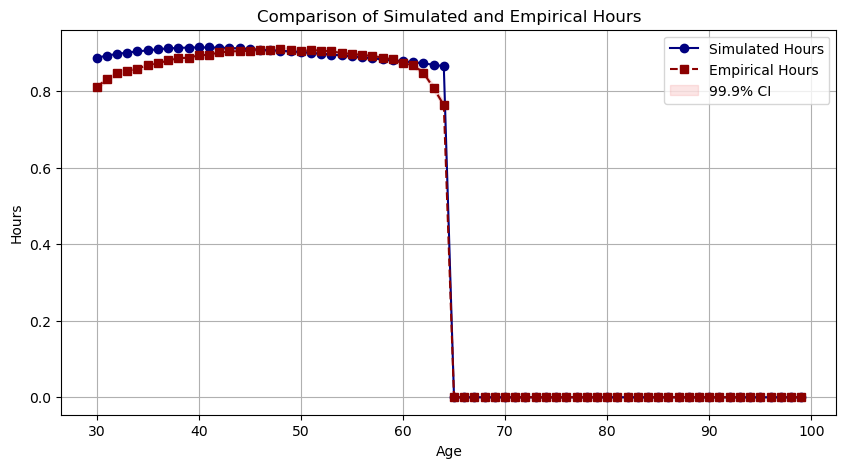

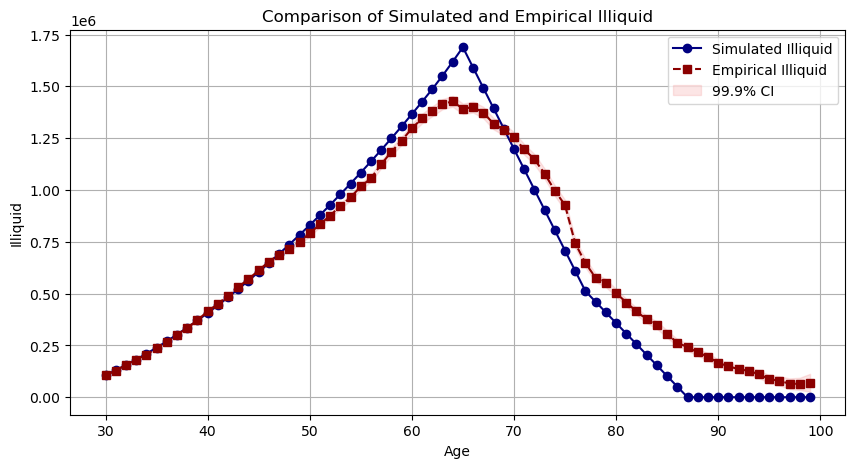

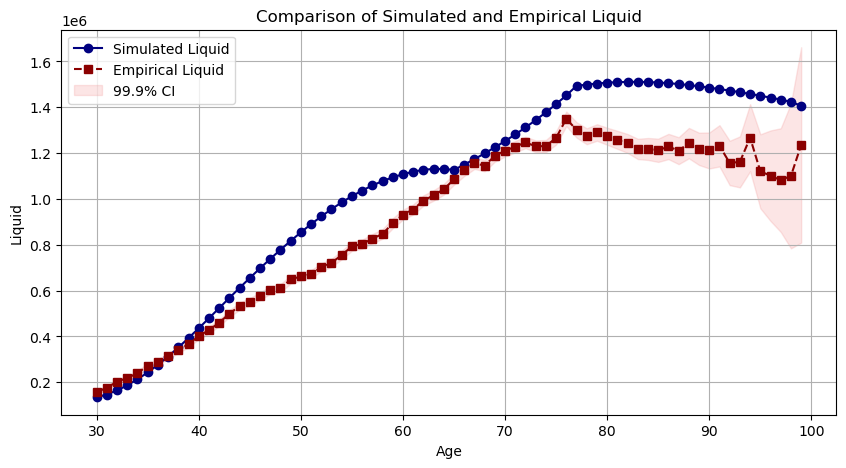

In [126]:
a_dict = {
    'hours': [np.mean(model.sim.h, axis=0), h_mean_full, h_stderr_full],
    'illiquid': [np.mean(model.sim.s, axis=0), s_mean, s_stderr],
    'liquid': [np.mean(model.sim.a, axis=0), a_mean, a_stderr]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical, stderr_dev) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # 99.9% confidence interval
    ci = 3.291 * stderr_dev
    plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.2, label="99.9% CI")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()

